Import libraries

In [17]:
from helpers import load_csv_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mie import split_categorical_continuous

Load data

In [18]:
data_path='data/dataset'
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

print("Number of samples of train: ", x_train.shape[0])
print("Number of features: ", x_train.shape[1])
print("Number of samples of test: ", x_test.shape[0])
print("Data type x_train:", x_train.dtype) 
print("Data type y_train:", y_train.dtype) 

Number of samples of train:  328135
Number of features:  321
Number of samples of test:  109379
Data type x_train: float64
Data type y_train: int64


Check types of variables

Total categorical features (<= 20 unique): 241
Total continuous features    (>  20 unique): 80


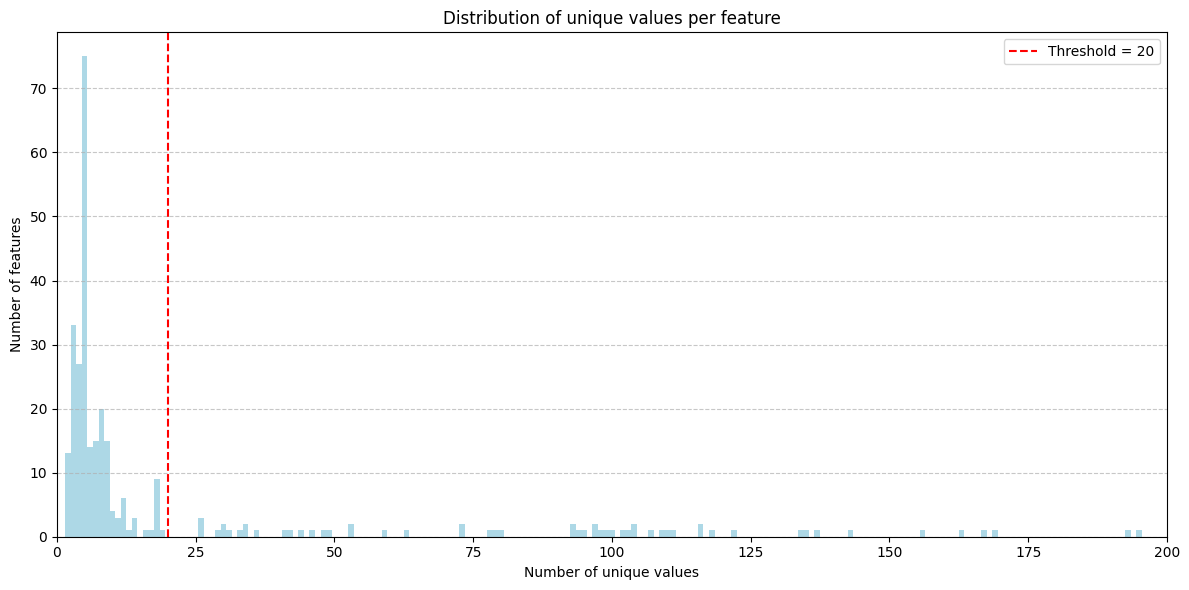

In [19]:
# Fixed threshold
threshold = 20
categorical_idx, continuous_idx, unique_counts = split_categorical_continuous(x_train, threshold=20)

# Classifies features as categorical or continuous
print(f"Total categorical features (<= {threshold} unique): {len(categorical_idx)}")
print(f"Total continuous features    (>  {threshold} unique): {len(continuous_idx)}")

# Build histrogram
unique_counts = np.array(unique_counts)
unique_vals, counts = np.unique(unique_counts, return_counts=True)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(unique_vals, counts, color='lightblue', width=1.0)
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel('Number of unique values')
plt.xlim(right=200)
plt.xlim(left=0)
plt.ylabel('Number of features')
plt.title('Distribution of unique values per feature')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Data cleaning from invalid values and NaN

In [20]:
def remove_outliers_categorical(X,  categorical_idx, threshold=0.95):
    """
    Replace anomalous or extreme values with np.nan
    threshold = limit quantile (e.g. 0.99 = over the 99° percentile)
    """
    X_clean = X.copy().astype(float)
    for i in range(X.shape[1]):
        if i not in categorical_idx: 
             continue
        col = X[:, i]
        col_valid = col[~np.isnan(col)]
        if len(col_valid) == 0:
            continue
        max_val = np.percentile(col_valid, threshold * 100)
        X_clean[col > max_val, i] = np.nan
    return X_clean

x_train_nan = remove_outliers_categorical(x_train,categorical_idx, threshold=0.95 )
x_test_nan = remove_outliers_categorical(x_test,categorical_idx, threshold=0.95 )

In [ ]:
nan_ratio = np.mean(np.isnan(x_train_nan), axis=0)
print(f"Number of features with more than 40% of NaN: {np.sum(nan_ratio>0.4)}")

# 1 Drop feature if at least 40% are NaN values
#1st change: 30% instead of 40%
valid_cols = np.where(nan_ratio < 0.4)[0]
x_train_clean = x_train_nan[:, valid_cols]
x_test_clean = x_test_nan[:, valid_cols]
print(f"Shape after dropping cols >40% NaN: {x_train_clean.shape}")

# 2 Identify categorical vs continuous
categorical_idx, continuous_idx, _ = split_categorical_continuous(x_train_clean, threshold=20)
print(f"Categorical features: {len(categorical_idx)}")
print(f"Continuous features: {len(continuous_idx)}")

# 4. Impute NaN differently
# 4a. Continuous → replace NaN with mean
for i in continuous_idx:
    median = np.nanmedian(x_train_clean[:, i])
    x_train_clean[np.isnan(x_train_clean[:, i]), i] = median
    x_test_clean[np.isnan(x_test_clean[:, i]), i] = median

# 4b. Categorical → replace NaN with mode
#def nanmode(col):
    #vals, counts = np.unique(col[~np.isnan(col)], return_counts=True)
    #return vals[np.argmax(counts)] if len(vals) > 0 else np.nan

# 4b. Categorical → replace NaN with -1
for i in categorical_idx:
    #mode_val = nanmode(x_train_clean[:, i])
    x_train_clean[np.isnan(x_train_clean[:, i]), i] = - 1
    x_test_clean[np.isnan(x_test_clean[:, i]), i] = - 1

print("Missing values imputed (median for continuous, -1 for categorical)")
print("Shape x_train_clean:", x_train_clean.shape)

Number of features with more than 40% of NaN: 158
Shape after dropping cols >40% NaN: (328135, 163)
Categorical features: 106
Continuous features: 57
Missing values imputed (median for continuous, -1 for categorical)
Shape x_train_clean: (328135, 163)


Data cleaning: highly correlated features (multicollinearity, e.g. different scales)

c:\Users\Pre_installer\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Pre_installer\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


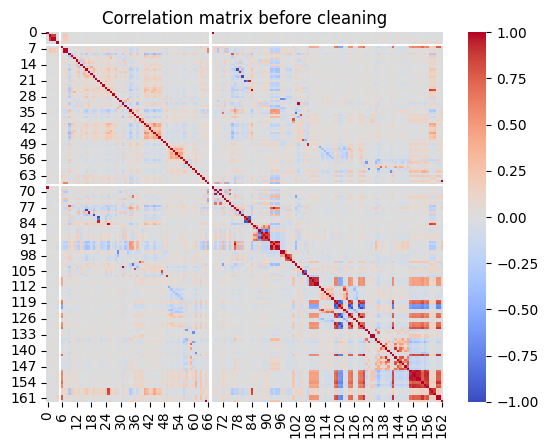

Shape of decorrelated X: (328135, 123)


In [22]:
# Cross-correlation among features
def corrcoef(X):
    n_features = X.shape[1]
    corr = np.empty((n_features, n_features))
    for i in range(n_features):
        for j in range(i, n_features):
            corr_ij = np.corrcoef(X[:, i], X[:, j])[0, 1]       # np.corrcoef returns correlation matrix of two 1D-arrays, corr_ij is in position [0,1]            
            corr[i, j] = corr_ij
            corr[j, i] = corr_ij  
    return corr

corr_matrix = corrcoef(x_train_clean)
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation matrix before cleaning')
plt.show()

# Drop features if correlation > 0.9

non_valid_col = set()  # Use set to avoid duplicates
for i in range(x_train_clean.shape[1]):
    for j in range(i + 1, x_train_clean.shape[1]):
        if abs(corr_matrix[i, j]) > 0.9:
            non_valid_col.add(j)  # Drop j, keep i

x_train_decorr = np.delete(x_train_clean, list(non_valid_col), axis=1)     # Remove column
x_test_decorr = np.delete(x_test_clean, list(non_valid_col), axis=1)
print(f"Shape of decorrelated X: {x_train_decorr.shape}")

Correlation with output

In [21]:
correlations = np.empty(x_train_decorr.shape[1])

for i in range(x_train_decorr.shape[1]):
    correlations[i] = np.corrcoef(x_train_decorr[:, i], y_train)[0, 1]
    
valid_features=np.where(np.abs(correlations)>=0.01)[0]
x_train_denoised=x_train_decorr[:,valid_features]
x_test_denoised=x_test_decorr[:,valid_features]

print(f"Shape after denoising: {x_train_denoised.shape}")

Shape after denoising: (328135, 102)


One hot encoding

In [ ]:
def one_hot_encode_columns(X, categorical_cols):
    """
    Applies one-hot encoding on categorical columns of x_train.
    Returns the new array and a dictionary with used categories.
    """
    X_encoded = []
    category_map = {}  # to remind which categories has every column

    for i in range(X.shape[1]):
        if i in categorical_cols:
            # unique values in the column
            values = np.unique(X[:, i])
            category_map[i] = values

            # Creates a one-hot matrix for each value
            one_hot = np.zeros((X.shape[0], len(values)))
            for j, val in enumerate(values):
                one_hot[:, j] = (X[:, i] == val).astype(float)
            
            X_encoded.append(one_hot)
        else:
            # leaves the numerical column unchanged
            X_encoded.append(X[:, i].astype(float).reshape(-1, 1))
    
    # final concatenation of all columns
    X_encoded = np.concatenate(X_encoded, axis=1)
    return X_encoded, category_map

def apply_one_hot_encoding(X, categorical_cols, category_map):
    """
    Applies the encoding to the test set using categories already found on the training set.
    If a category is not present in the training, it is ignored (0 column).
    """
    X_encoded = []

    for i in range(X.shape[1]):
        if i in categorical_cols:
            values = category_map[i]
            one_hot = np.zeros((X.shape[0], len(values)))
            for j, val in enumerate(values):
                one_hot[:, j] = (X[:, i] == val).astype(float)
            X_encoded.append(one_hot)
        else:
            X_encoded.append(X[:, i].astype(float).reshape(-1, 1))

    X_encoded = np.concatenate(X_encoded, axis=1)
    return X_encoded

threshold = 20
categorical_idx, continuous_idx, _ = split_categorical_continuous(x_train_decorr, threshold=20)

X_train_encoded, category_map =  one_hot_encode_columns(x_train_decorr, categorical_idx)
X_test_encoded = apply_one_hot_encoding(x_test_decorr, categorical_idx, category_map)
print(X_train_encoded.shape)

(328135, 305)


In [24]:
rank = np.linalg.matrix_rank(X_train_encoded)

print(f"Number of features: {X_train_encoded.shape[1]}")
print(f"Rank of the matrix: {rank}")

if rank < X_train_encoded.shape[1]:
    print("Some features are linearly dependent!")


Number of features: 305
Rank of the matrix: 177
Some features are linearly dependent!


Z-score normalization

In [25]:
# Ricostruisci indici delle colonne continue dopo il one-hot encoding
n_features_original = x_train_decorr.shape[1]
continuous_mask = np.ones(n_features_original, dtype=bool)
continuous_mask[categorical_idx] = False

new_continuous_idx = []
col_counter = 0

for i in range(n_features_original):
    if continuous_mask[i]:
        # feature continua → una sola colonna
        new_continuous_idx.append(col_counter)
        col_counter += 1
    else:
        # feature categoriale → tante colonne quante categorie
        n_values = len(category_map[i])
        col_counter += n_values

print(f"Numero di colonne continue dopo one-hot: {len(new_continuous_idx)}")

col_mean = np.mean(X_train_encoded[:, new_continuous_idx], axis=0)
col_std = np.std(X_train_encoded[:, new_continuous_idx], axis=0)

x_train_norm = X_train_encoded.copy()
x_train_norm[:, new_continuous_idx] = (X_train_encoded[:, new_continuous_idx] - col_mean) / col_std
x_test_norm = X_test_encoded.copy()
x_test_norm[:, new_continuous_idx] = (X_test_encoded[:, new_continuous_idx] - col_mean) / col_std

col_mean_tr = np.mean(x_train_norm[:, new_continuous_idx], axis=0)
col_std_tr = np.std(x_train_norm[:, new_continuous_idx], axis=0)

print(f"Before normalization, mean: {col_mean[0:3]}, std: {col_std[0:3]}")
print(f"After normalization, mean: {col_mean_tr[0:3]}, std: {col_std_tr[0:3]}")

Numero di colonne continue dopo one-hot: 48
Before normalization, mean: [2.99736511e+01 6.56363820e+06 1.44962348e+01], std: [1.60317529e+01 3.48924235e+06 8.33448235e+00]
After normalization, mean: [-9.80492025e-17 -6.23634504e-18 -9.84822821e-17], std: [1. 1. 1.]


Classes distribution

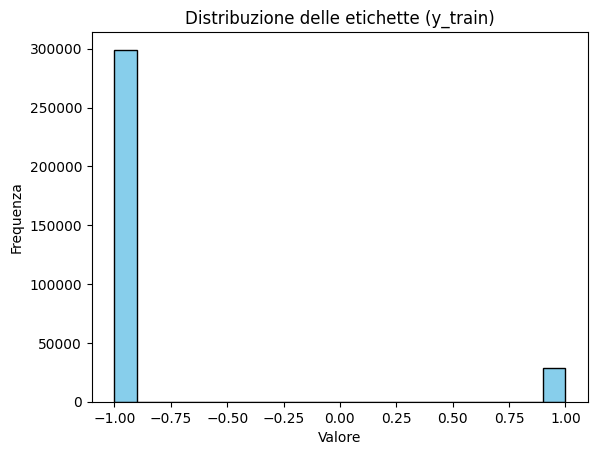

In [26]:
plt.hist(y_train, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribuzione delle etichette (y_train)")
plt.xlabel("Valore")
plt.ylabel("Frequenza")
plt.show()

Save

In [ ]:
np.save("processed/x_train.npy", x_train_norm)
np.save("processed/x_test.npy", x_test_norm)
np.save("processed/y_train.npy", y_train)
np.save("processed/train_ids.npy", train_ids)
np.save("processed/test_ids.npy", test_ids)